<a href="https://colab.research.google.com/github/jasreman8/Single-Agent-Systems/blob/main/SQL_ReAct_Agent_Using_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Understand how to build a basic AI agent that can interact with external tools (specifically, a SQL database).
- Learn how to utilize LangGraph's `create_react_agent` prebuilt function to quickly set up a ReAct (Reason and Act) agent workflow.
- See how to configure and use LangChain's `SQLDatabaseToolkit` to provide the agent with the necessary capabilities to query database schemas, list tables, and execute SQL queries.

 - The ReAct agent workflow enables the agent to break down complex tasks into smaller steps, improving decision-making and problem-solving capabilities.

# Setup

In [1]:
!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain-community==0.3.19 \
                langgraph==0.3.21 \
                grandalf==0.8

In [2]:
from typing import Annotated, List, TypedDict

from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase

from langgraph.prebuilt import create_react_agent

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

from google.colab import userdata

# TypedDict is a data structure from Python's typing module, used to define dictionaries with a fixed set of keys, where each key has a specific type of value.

In [3]:
openai_api_key = userdata.get('OPEN_API_KEY')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o-mini',
    temperature=0
)

# Business Scenario

A company stores its credit card transaction data in a SQL database (`ccms.db`). Business analysts or customer support representatives, who may not be proficient in SQL, need to quickly retrieve specific information from this database (e.g., top spending cities, transaction counts for merchants, spending patterns by card type).

**Solution:** This AI agent acts as a natural language interface to the database. Instead of writing complex SQL queries, users can ask questions in plain English like "Who are the top 5 merchants by total transactions?". The agent understands the question, interacts with the database using its tools (checking schema, generating and executing SQL), and provides the answer directly to the user. This democratizes data access and speeds up information retrieval for non-technical users.

# Implementation Overview

1. **Goal:** Create an AI assistant that translates natural language questions into SQL queries, executes them against a specific database, and returns the answers.

2. **Core Components:**
- Language Model (LLM): gpt-4o-mini via ChatOpenAI is chosen for its strong reasoning and instruction-following capabilities, essential for understanding questions and generating correct SQL.
- Database: A SQLite database (`ccms.db`) containing the relevant data. SQLDatabase provides the connection interface.
- Tools: We need specific actions the agent can perform on the database. **SQLDatabaseToolkit** is ideal as it automatically generates standard tools: `sql_db_list_tables`, `sql_db_schema`, `sql_db_query`, `sql_db_query_checker`. These cover the essential steps for database interaction (discovery, query generation, execution, validation).
- Agent Framework: We need a way to orchestrate the interaction between the LLM and the tools. LangGraph is chosen for its explicit state management and graph-based control flow.
- Agent Logic (ReAct): The agent needs to reason about the user's query, decide which tool to use (e.g., check schema first, then query), execute the tool, observe the result, and potentially retry or formulate a final answer. The ReAct pattern is well-suited for this.

3. **Implementation Strategy:**
- Simplify with Prebuilt: Instead of manually defining the ReAct loop nodes and edges in LangGraph (agent node, tool node, conditional edges), we use langgraph.prebuilt.create_react_agent.
- Rationale for `create_react_agent`: This function encapsulates the standard ReAct logic. It automatically creates a graph that:
    - Takes user input.
    - Passes the input and instructions (system prompt) to the LLM.
    - Checks if the LLM wants to call a tool.
    - If yes, executes the tool via a built-in ToolNode.
    - Feeds the tool's output back to the LLM.
    - Repeats until the LLM generates a final answer without a tool call.
- This significantly reduces boilerplate code compared to manual graph construction.

4. **Configuration:**
    - Provide the initialized `llm` and the `sql_db_toolkit_tools` list to `create_react_agent`.
    - Supply detailed instructions via the prompt argument (as a `system_prompt_string`). This guides the LLM on how to use the tools effectively and safely (e.g., query limits, checking queries, restrictions).

5. **Execution:** Invoke the created agent (`sql_agent`) with the user's query formatted within the standard `{"messages": [...]}` structure. Extract the final answer from the last message in the output state.

# Database Schema

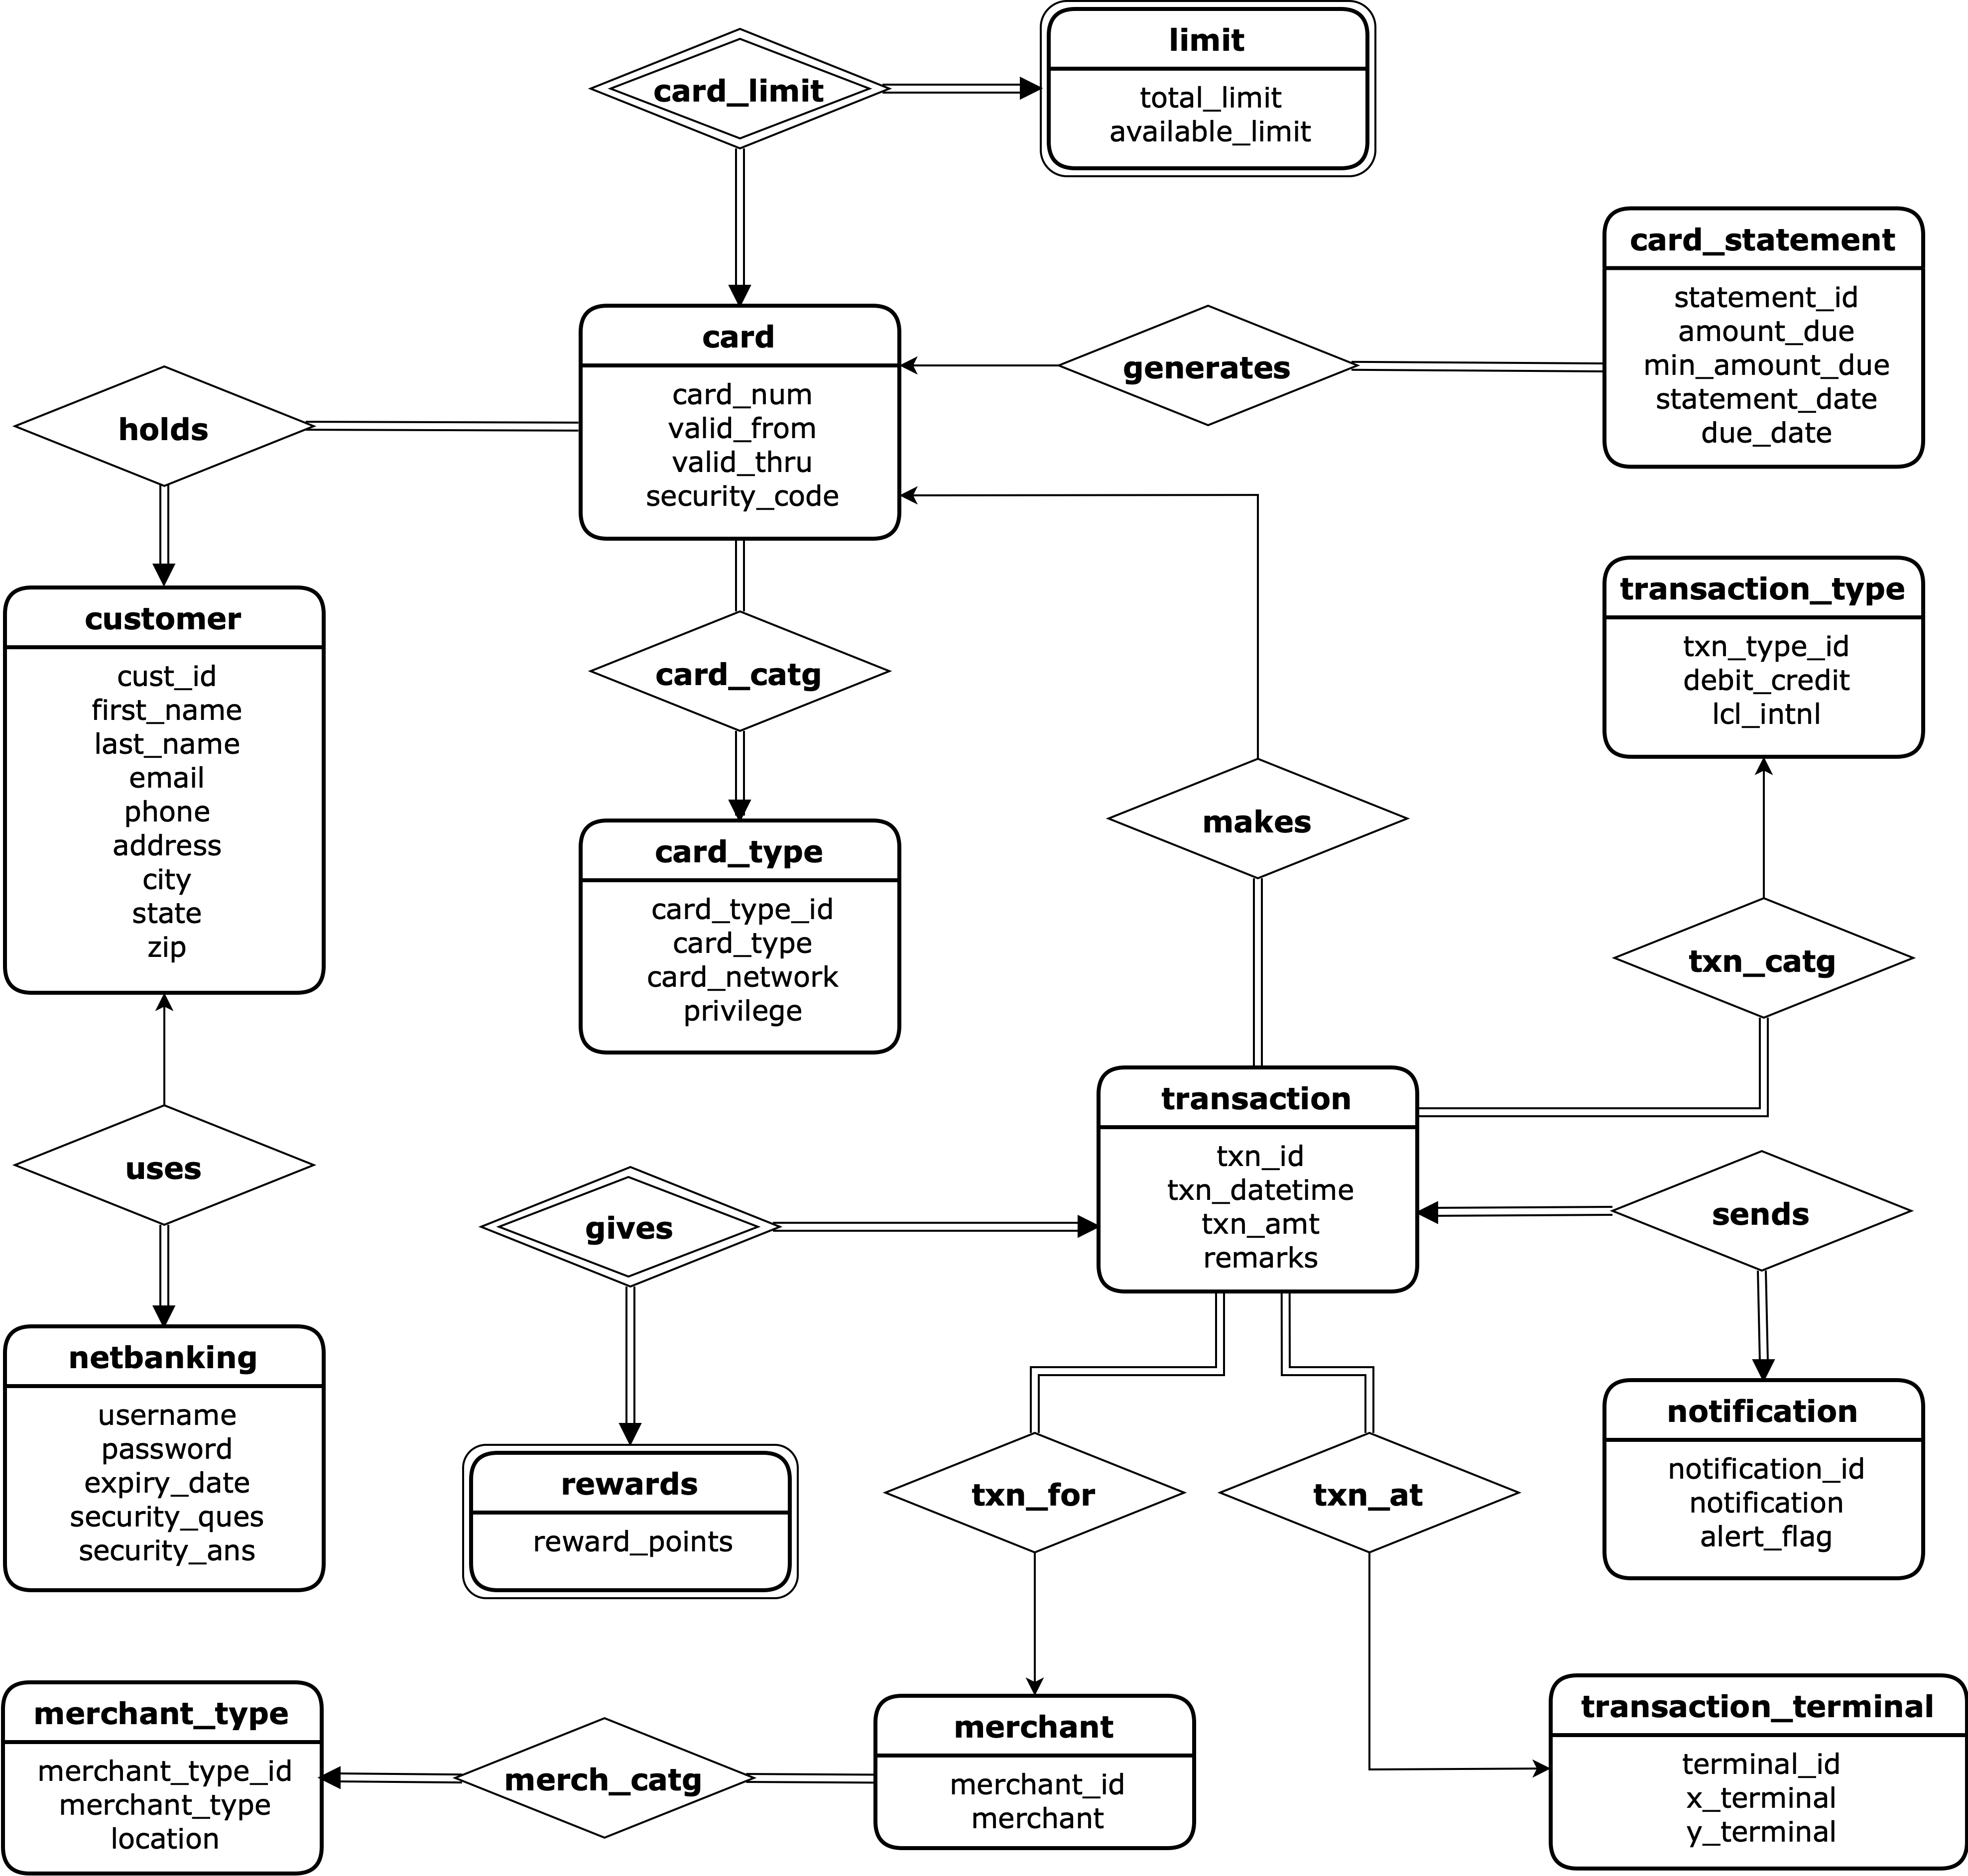

(Source: https://github.com/shrivastavasatyam/Credit-Card-Management-System)

In the below code block, `credit_card_db = SQLDatabase.from_uri(...)` creates an instance of the SQLDatabase connector, pointing it to the SQLite database file named ccms.db located in the same directory. The r"" denotes a raw string, preventing backslashes from being interpreted as escape sequences (though less critical here).


In [4]:
credit_card_db = SQLDatabase.from_uri(r"sqlite:///ccms.db")

In [5]:
toolkit = SQLDatabaseToolkit(db=credit_card_db, llm=llm)
sql_db_toolkit_tools = toolkit.get_tools()

In [6]:
print("--- Available Tools ---")
for tool in sql_db_toolkit_tools:
    print(tool.name)
print("-" * 20)

--- Available Tools ---
sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker
--------------------


In the above code block:
- `toolkit = SQLDatabaseToolkit(...)`: Initializes the SQL toolkit, providing it with the database connection (db) and the language model (llm). The LLM is sometimes used by the toolkit itself for more complex operations or descriptions, although primarily the agent uses the LLM.

- `sql_db_toolkit_tools = toolkit.get_tools()`: Calls the method to automatically generate a list of standard LangChain Tool objects suitable for SQL interaction. These tools typically include:
    - `sql_db_query`: Executes a SQL query.
    - `sql_db_schema`: Gets the schema (table structure) for specified tables.
    - `sql_db_list_tables`: Lists all tables in the database.
    - `sql_db_query_checker`: Checks a SQL query for basic syntax errors (often using the LLM).

In [7]:
system_prompt_string = """You are an expert AI assistant specialized in generating and executing SQLite queries against a database.
Your primary goal is to accurately answer user questions based *only* on the data retrieved. You must be methodical in exploring the database structure.

<Schema Exploration and Join Path Strategy>
1.  **List All Tables:** Always start with `sql_db_list_tables`.
2.  **Identify Potential Tables:** List tables potentially holding the requested entities (e.g., cities, merchants) and metrics (e.g., spend). Also, identify tables that might *link* these entities (often containing ID columns like `cust_id`, `CARD_ID`, `M_ID`).
3.  **Get Schemas Systematically:** Use `sql_db_schema` to get schemas for *all* tables identified in step 2. This is crucial. Do not skip potential linking tables.
4.  **Map the Join Path:**
    *   Explicitly identify the column containing the primary metric (e.g., `transaction.TX_AMOUNT`).
    *   Explicitly identify the column containing the target entity (e.g., `customer.city`).
    *   **CRITICAL:** Trace the connections between these tables using ID columns revealed in the schemas. Look for sequences like `tableA.ID -> tableB.tableA_ID`, `tableB.ID -> tableC.tableB_ID`.
    *   **Example Path:** To link transaction spend to customer city, you MUST verify the path: `transaction.CARD_ID` links to `card.card_number`, AND `card.cust_id` links to `customer.cust_id`. You **MUST** request the schema for the `card` table to confirm this.
    *   **State the Path:** Before writing the query, state the full join path you intend to use (e.g., "Found path: transaction JOIN card ON transaction.CARD_ID = card.card_number JOIN customer ON card.cust_id = customer.cust_id").
5.  **Verify Columns:** Double-check that *every* column used in your intended SELECT, JOIN, WHERE, GROUP BY, or ORDER BY clauses exists in the schemas you retrieved.
</Schema Exploration and Join Path Strategy>

<Query Construction and Execution>
6.  **Construct Query:** Build the SQLite query using the verified tables, columns, and the full, correct join path.
    *   Use explicit JOIN clauses (INNER JOIN is usually appropriate unless otherwise specified).
    *   Quote identifiers (like `"transaction"`) if they are keywords or contain special characters.
    *   Select only necessary columns. Alias columns for clarity if needed (e.g., `SUM(t.TX_AMOUNT) AS total_spend`).
    *   Include calculations like percentage contribution if requested. The total sum for percentage calculation should be derived correctly (e.g., `(SELECT SUM(TX_AMOUNT) FROM "transaction")`).
    *   Apply `GROUP BY` to the target entity column (e.g., `c.city`).
    *   Apply `ORDER BY` and `LIMIT 5` (unless otherwise specified).
7.  **Validate Query:** Use `sql_db_query_checker`. Revise if syntax errors occur.
8.  **Execute Query:** Use `sql_db_query`.
9.  **Formulate Answer:** Base the final answer *strictly* on the query results. If the query returns no results *after* confirming a valid join path and correct syntax, state that no data matching the criteria was found.
10. **Handle Missing Information:** If, after thorough schema exploration (including checking potential linking tables), you cannot find the requested column (e.g., 'country') or a valid join path, *then and only then* inform the user the data is unavailable. Do not substitute unrelated columns.
11. **Final Answer Only:** Provide the answer directly without further tool calls once results are obtained.
</Query Construction and Execution>

<General Restrictions>
1. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.).
2. DO NOT MAKE UP ANSWERS.
</General Restrictions>
"""

In the above code block, the `system_prompt_string = """..."""` defines a multi-line string containing detailed instructions for the LLM agent. This prompt is crucial for guiding the agent's behavior and was arrived upon after several iterations on difficult edge cases.

**Overall Goal:**

The primary objective of this prompt is to transform the LLM from a general-purpose reasoner into a highly methodical and careful SQL Query Specialist. It aims to overcome the typical SQL failures (hallucinating columns, making incorrect joins, failing to find multi-hop paths) by providing a very explicit, step-by-step algorithm for interacting with the database schema and constructing queries.

**Key Principle:** Explicit Instruction & Process Guidance

Instead of just stating the goal (answer the question using SQL), this prompt dictates a precise process the agent MUST follow. This is crucial because LLMs, while powerful, can sometimes take shortcuts or fail to perform exhaustive searches unless explicitly instructed.

**Detailed Explanation of Key Sections and Wording:**

1. Schema Exploration and Join Path Strategy - The Core

    Why a Dedicated Section? This section directly addresses the most significant failure point: understanding the database structure and identifying how tables connect. Separating it emphasizes its importance.

    - List All Tables: Always start with sql_db_list_tables.

    Rationale: Forces a global view from the outset. Prevents the agent from prematurely focusing on only one or two tables and missing crucial linking tables (like the card table in our case). The word "Always" makes it a non-negotiable first step.

    - Identify Potential Tables: ... Also, identify tables that might *link* these entities...

    Rationale: Explicitly tells the agent to think not just about tables containing the final answer elements (city, spend) but also about the intermediate tables needed to connect them. Using "link" guides its thinking towards join relationships.

    - Get Schemas Systematically: ... for *all* potentially relevant tables... Do not skip potential linking tables.

    Rationale: Reinforces the need for completeness. Prevents the agent from deciding prematurely that it doesn't need the schema for a table like card. The phrase "Do not skip" directly counters the observed failure mode. "Systematically" encourages a methodical approach rather than guessing.

    - Map the Join Path:

    Rationale: This is the most detailed instruction, directly targeting the multi-hop join failure.

    Explicitly identify... : Forces the agent to pinpoint the start (metric) and end (entity) columns it needs to connect.

    CRITICAL: Trace the connections... Look for sequences...: Elevates the importance of finding the step-by-step path using ID columns. The word "CRITICAL" signals high priority.

    Example Path: ... You MUST request the schema for thecardtable to confirm this.: This is crucial scaffolding and direct instruction. By providing the known correct path for this specific problem (transaction -> card -> customer) and explicitly stating the need to check the card schema, we give the LLM a strong template and directly address the previous oversight. The word "MUST" leaves no room for interpretation.

    State the Path:: This forces the agent to articulate its plan before coding. It acts as a self-check and makes the agent's reasoning transparent in the trace, allowing easier debugging if it still gets the path wrong.

    - Verify Columns:

    Rationale: A final sanity check to prevent errors caused by typos or misremembering column names after mapping the path.

2. Query Construction and Execution - Building on a Solid Foundation

    Rationale: This section assumes the schema and join path are now correctly understood (thanks to the previous section) and focuses on building and executing the query correctly.

    - Construct Query: ... using the verified tables, columns, and the full, correct join path.: Explicitly links query construction back to the validated plan.

    - Quote identifiers (like "transaction")...: Directly addresses the syntax error encountered earlier with SQL keywords.

    - Include calculations... The total sum... should be derived correctly...: Provides guidance on more complex query elements like percentage calculations, aiming for accuracy.

    - Validate Query: Use sql_db_query_checker.: Standard practice, reinforces using the validation tool.

    - Formulate Answer: ... If the query returns no results *after* confirming a valid join path and correct syntax...: This refines the handling of empty results. It distinguishes between "no results because the query logic was flawed" (which shouldn't happen if steps 1-5 were followed) and "no results because no data actually matches the valid criteria".

    - Handle Missing Information: If, after thorough schema exploration... then and only then...: This instruction is now positioned correctly - after the agent has supposedly done its due diligence in exploring joins. The phrase "then and only then" emphasizes that reporting missing data is a last resort, not an initial assumption. It also reiterates "Do not substitute unrelated columns" to prevent the initial error (using merchant for city).

3. Directive Language (MUST, CRITICAL, Always, Explicitly)

    Rationale: Standard conversational prompts allow LLMs more interpretive freedom. For precise, algorithmic tasks like SQL generation based on complex schemas, this freedom can lead to errors or shortcuts. Using strong, directive modal verbs and adverbs reduces ambiguity and forces the LLM to adhere more strictly to the prescribed process. It's akin to giving commands rather than suggestions.

In Summary:

This prompt explicitly:

- Mandates a systematic, multi-step process for schema exploration.

- Forces the agent to identify and consider potential linking tables.

- Requires the agent to articulate its planned join path before coding.

- Provides specific examples and strong directives (MUST, CRITICAL) to guide the reasoning, especially around the known tricky join path.

- Clarifies the correct interpretation of "no results" based on whether the query logic itself was sound.

It essentially provides a detailed algorithm within the prompt, significantly constraining the agent's behavior towards a more robust and accurate method for tackling complex SQL queries involving joins.

In [8]:
sql_agent = create_react_agent(
    model=llm,                  # The language model (LanguageModelLike)
    tools=sql_db_toolkit_tools, # The sequence of tools (Sequence[BaseTool])
    prompt=system_prompt_string # System instructions as a string (str)
)

This is the core step where the LangGraph agent is constructed using the prebuilt function.
- `model=llm`: Passes the initialized language model.
- `tools=sql_db_toolkit_tools`: Provides the list of SQL tools the agent can use.
- `prompt=system_prompt_string`: Supplies the system instructions defined earlier.

This function call internally builds and compiles a StateGraph representing the ReAct logic (LLM thinks -> decides tool -> executes tool -> observes result -> LLM thinks again...). The resulting sql_agent is a callable LangGraph CompiledGraph.

In [9]:
try:
    sql_agent.get_graph().draw_mermaid_png(output_file_path="sql-agent-react-prebuilt-api.png")
except Exception as e:
    sql_agent.get_graph().print_ascii()

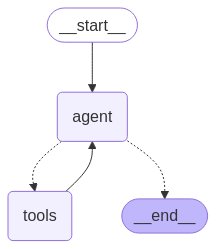

### Example 1

In [10]:
query = "Who are the top 3 merchants by total transactions?"

In [11]:
inputs = {"messages": [HumanMessage(content=query)]}

In [12]:
response = sql_agent.invoke(inputs, config={"recursion_limit": 100})

In [13]:
print(response['messages'][-1].content)

The top 3 merchants by total transactions are:

1. Amazon - 22,361 transactions
2. Walgreens Boots Alliance - 22,267 transactions
3. Best Buy - 22,256 transactions


In [14]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Who are the top 3 merchants by total transactions?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_ciwbAzCUpQyBWJ1OH1kFPzcH)
 Call ID: call_ciwbAzCUpQyBWJ1OH1kFPzcH
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

card, card_type, customer, merchant, merchant_type, netbanking, transaction, transaction_terminal, transaction_type
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_7BR6rH9wIgOL0KqkMM0CHjQH)
 Call ID: call_7BR6rH9wIgOL0KqkMM0CHjQH
  Args:
    table_names: merchant
  sql_db_schema (call_3HrUmvNhsSgz8xKY4WjsumpQ)
 Call ID: call_3HrUmvNhsSgz8xKY4WjsumpQ
  Args:
    table_names: transaction
================================= Tool Message =================================
Name: sql_db_schema


CREATE 

Before we move on to more examples, let us follow the trace step-by-step, highlighting the ReAct cycle:
1. Input: Human Message: "Who are the top 5 merchants by total transactions?"
    This is the initial problem statement.

2. Cycle 1: Initial Planning & Schema Discovery
    - Reason (Implicit): The agent needs to understand the database structure to find merchants and transactions. Based on its system prompt, the first step is to explore the schema. It likely decides to list tables first.
    - Act: Calls sql_db_list_tables.
    - Observe: Receives the list of tables (card, customer, merchant, transaction, etc.).

3. Cycle 2: Focusing on Relevant Tables
    - Reason (Implicit): Based on the table list and the query ("merchants", "transactions"), the agent identifies merchant and transaction as the most relevant tables. It needs their specific structure (columns and types).
    - Act: Calls sql_db_schema for merchant and sql_db_schema for transaction.
    - Observe: Receives the CREATE TABLE statements and sample rows for both tables.

4. Cycle 3: Explicit Reasoning, Planning, and Validation
    - Reason (Explicitly shown in AI Message): This is a key demonstration of ReAct. The agent explicitly articulates its thought process based on the observations from Cycle 2:
    Confirms relevant tables (merchant, transaction).
    Identifies key columns (id, merchant, M_ID, TXN_ID).
    Determines the correct join path (transaction JOIN merchant ON transaction.M_ID = merchant.id).
    Constructs the SQL query (SELECT m.merchant, COUNT(t.TXN_ID)...).
    States its next intention ("I will now validate this query.").
    - Act: Calls sql_db_query_checker with the constructed query.
    - Observe: Receives the validated query back (indicating correct syntax).

5. Cycle 4: Query Execution Attempt
    - Reason (Implicit): The query syntax is valid, so the next logical step is to execute it against the database to get the data.
    - Act: Calls sql_db_query with the validated query.
    - Observe: Receives an OperationalError: near "transaction": syntax error. The execution failed.

6. Cycle 5: Error Diagnosis, Correction Plan, and Re-Validation
    - Reason (Explicitly shown): Another strong ReAct example. The agent observes the error and reasons about its cause ("table name transaction is causing a syntax error because it is a reserved keyword"). It formulates a plan ("I will quote the table name"). It creates the revised query with quotes. It states its next intention ("I will validate this revised query now.").
    - Act: Calls sql_db_query_checker with the revised query.
    - Observe: Receives the validated revised query back (syntax is now correct).

7. Cycle 6: Retry Query Execution
    - Reason (Implicit): The revised query's syntax is valid. Time to execute this version.
    - Act: Calls sql_db_query with the revised query.
    - Observe: Receives the actual query results: [('Amazon', 22361), ...]. Success!

8. Cycle 7: Final Answer Generation
    - Reason (Implicit): The agent has successfully retrieved the required data from the database via its actions and observations. The final step is to synthesize this data into a user-friendly answer.
    - Act (Final Response - No Tool Call): Generates the natural language response: "The top 5 merchants by total transactions are: ..."

In Summary:
The trace clearly shows the `sql_agent`, powered by `create_react_agent`, following the ReAct paradigm:
- It doesn't just guess the final query; it breaks the problem down.
- It uses tools (Act) like `sql_db_list_tables`, `sql_db_schema`, `sql_db_query_checker`, and `sql_db_query` strategically.
- It explicitly shows its reasoning (Reason) at key points, particularly when planning the query and when reacting to the SQL error.
- Each tool's output (Observe) directly informs the subsequent reasoning and action, allowing it to refine its approach (e.g., fixing the SQL syntax error).
- The process iterates (Reason -> Act -> Observe -> Reason...) until the goal is achieved and a final answer can be generated.

### Example 2

In [15]:
query = "Which is the highest spend month and amount for each card type?"

In [16]:
inputs = {"messages": [HumanMessage(content=query)]}

In [17]:
response = sql_agent.invoke(inputs, config={"recursion_limit": 100})

In [18]:
print(response['messages'][-1].content)

The highest spend month and amount for each card type are as follows:

- **Bronze**
  - August 2022: $843,170.05
  - July 2022: $835,855.28
  - June 2022: $803,257.77
  - September 2022: $220,813.24

- **Diamond**
  - July 2022: $995,727.57
  - August 2022: $991,110.29
  - June 2022: $958,856.98
  - September 2022: $255,764.65

- **Gold**
  - August 2022: $977,467.10
  - July 2022: $957,205.06
  - June 2022: $946,313.98
  - September 2022: $250,308.75

- **Platinum**
  - August 2022: $990,441.89
  - July 2022: $975,432.41
  - June 2022: $963,588.27
  - September 2022: $245,564.01

- **Silver**
  - July 2022: $913,766.53
  - August 2022: $898,492.29
  - June 2022: $879,042.23
  - September 2022: $228,883.89

This data shows the total spend for each card type by month, with the highest amounts listed first.


In [19]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Which is the highest spend month and amount for each card type?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_GBovZ3Ws1dgCa778kfrHD1Pg)
 Call ID: call_GBovZ3Ws1dgCa778kfrHD1Pg
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

card, card_type, customer, merchant, merchant_type, netbanking, transaction, transaction_terminal, transaction_type
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_6qciDnlD16piu8hTnozXjseO)
 Call ID: call_6qciDnlD16piu8hTnozXjseO
  Args:
    table_names: transaction
  sql_db_schema (call_fvcmwNeRHJ8OXylmfAUhREhy)
 Call ID: call_fvcmwNeRHJ8OXylmfAUhREhy
  Args:
    table_names: card
  sql_db_schema (call_pPISLxotJFboe6qoBRwGBo0d)
 Call ID: call_pPISLxotJFboe6qoBRwGBo0d
  Args:
    t

### Example 3

In [20]:
query = "Which are the top 5 cities with the highest spend and what is their percentage contribution to overall spends?"

In [21]:
inputs = {"messages": [HumanMessage(content=query)]}

In [22]:
response = sql_agent.invoke(inputs, config={"recursion_limit": 30})

In [23]:
print(response['messages'][-1].content)

The top 5 cities with the highest spend and their percentage contribution to overall spends are as follows:

1. **Arvada**: Total Spend = $1,167,419.36, Percentage Contribution = 7.72%
2. **Anchorage**: Total Spend = $916,297.73, Percentage Contribution = 6.06%
3. **Nashville**: Total Spend = $861,607.85, Percentage Contribution = 5.69%
4. **Fayetteville**: Total Spend = $857,231.08, Percentage Contribution = 5.67%
5. **Glendale**: Total Spend = $825,556.59, Percentage Contribution = 5.46%


In [24]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Which are the top 5 cities with the highest spend and what is their percentage contribution to overall spends?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_QfwPvG7lLFfJ4Km4B7JNyRA9)
 Call ID: call_QfwPvG7lLFfJ4Km4B7JNyRA9
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

card, card_type, customer, merchant, merchant_type, netbanking, transaction, transaction_terminal, transaction_type
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_BoqX7rcqTIUv4zdSYuZJWrld)
 Call ID: call_BoqX7rcqTIUv4zdSYuZJWrld
  Args:
    table_names: transaction
  sql_db_schema (call_vwGVWXgAT9aZSZePg07Vruit)
 Call ID: call_vwGVWXgAT9aZSZePg07Vruit
  Args:
    table_names: customer
================================= Tool Message ===